Reference:
1. https://medium.com/towards-data-science/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923

In [1]:
from torchvision.datasets import OxfordIIITPet

pet_trainval = OxfordIIITPet(root="data", split="trainval", target_types="segmentation", download=True)
pet_test = OxfordIIITPet(root="data", split="test", target_types="segmentation", download=True)
pet_trainval, pet_test

(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: data,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: data)

tensor([1, 2, 3], dtype=torch.uint8)

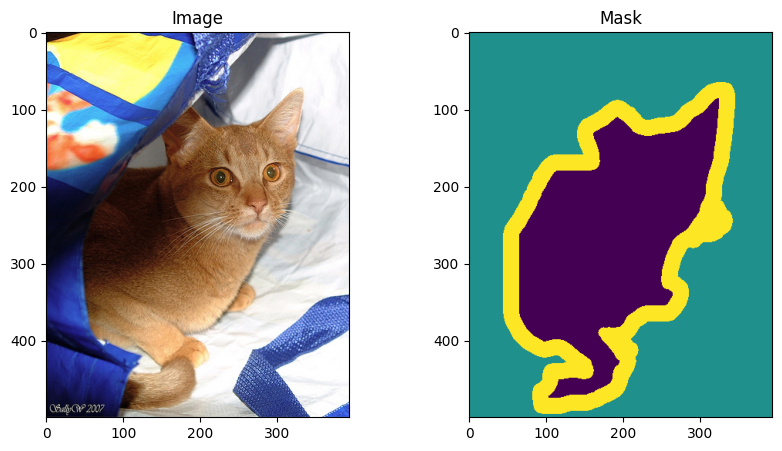

In [2]:
import matplotlib.pyplot as plt
from torch import unique
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

image: Image = pet_trainval[0][0]
mask: Image = pet_trainval[0][1]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Mask")

unique(pil_to_tensor(mask)) # Trimap: 1=Pet, 2=Background, 3=Border

In [3]:
from torchinfo import summary
from torch.nn import Linear

model = Linear(1000, 500) # no # of parameters = 1000*500 (weights) + 500 (bias) = 500500
summary(
  model,
  input_size=(1, 1000),
  col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
  col_width=15,
)

Layer (type:depth-idx)                   Kernel Shape    Output Shape    Param #         Mult-Adds
Linear                                   --              [1, 500]        500,500         500,500
Total params: 500,500
Trainable params: 500,500
Non-trainable params: 0
Total mult-adds (M): 0.50
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.00
Estimated Total Size (MB): 2.01

Reference:
1. https://medium.com/p/bed68cadd7c7

In [4]:
from importlib import reload
from src import oxford_iiit_pet_augmented, to_device, utils
reload(oxford_iiit_pet_augmented)
reload(to_device)
reload(utils)
OxfordIIITPetAugmented = oxford_iiit_pet_augmented.OxfordIIITPetAugmented
ToDevice = to_device.ToDevice
float_to_long = utils.float_to_long
get_device = to_device.get_device
from torchvision.transforms import (ToTensor, Compose, Resize, InterpolationMode, 
                                    RandomHorizontalFlip, ColorJitter, Lambda)

pre_transform = ToTensor()
pre_target_transform = ToTensor()
common_transform = Compose([
    ToDevice(get_device()),
    Resize((128, 128), interpolation=InterpolationMode.NEAREST),
    RandomHorizontalFlip(p=0.5)
])
post_transform = Compose([
    ColorJitter(contrast=0.3)
])
post_target_transform = Compose([
    Lambda(float_to_long)
])
pet_trainval = OxfordIIITPetAugmented(root="data", split="trainval", target_types="segmentation", 
                                      download=True, 
                                      pre_transform=pre_transform,
                                      pre_target_transform=pre_target_transform,
                                      common_transform=common_transform,
                                      post_transform=post_transform,
                                      post_target_transform=post_target_transform)
pet_test = OxfordIIITPetAugmented(root="data", split="test", target_types="segmentation",
                                  download=True,
                                  pre_transform=pre_transform,
                                  pre_target_transform=pre_target_transform,
                                  common_transform=common_transform,
                                  post_transform=post_transform,
                                  post_target_transform=post_target_transform)
pet_trainval, pet_test

(Dataset OxfordIIITPetAugmented
     Number of datapoints: 3680
     Root location: data
     StandardTransform
 Transform: ToTensor()
 Target transform: ToTensor(),
 Dataset OxfordIIITPetAugmented
     Number of datapoints: 3669
     Root location: data
     StandardTransform
 Transform: ToTensor()
 Target transform: ToTensor())

In [5]:
from torch.utils.data import DataLoader

pet_trainval_loader = DataLoader(pet_trainval, batch_size=64, shuffle=True)
pet_test_loader = DataLoader(pet_test, batch_size=21, shuffle=True)

pet_trainval_inputs, pet_trainval_masks = next(iter(pet_trainval_loader))
pet_test_inputs, pet_test_masks = next(iter(pet_test_loader))
pet_trainval_inputs.shape, pet_trainval_masks.shape, pet_test_inputs.shape, pet_test_masks.shape

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 1, 128, 128]),
 torch.Size([21, 3, 128, 128]),
 torch.Size([21, 1, 128, 128]))

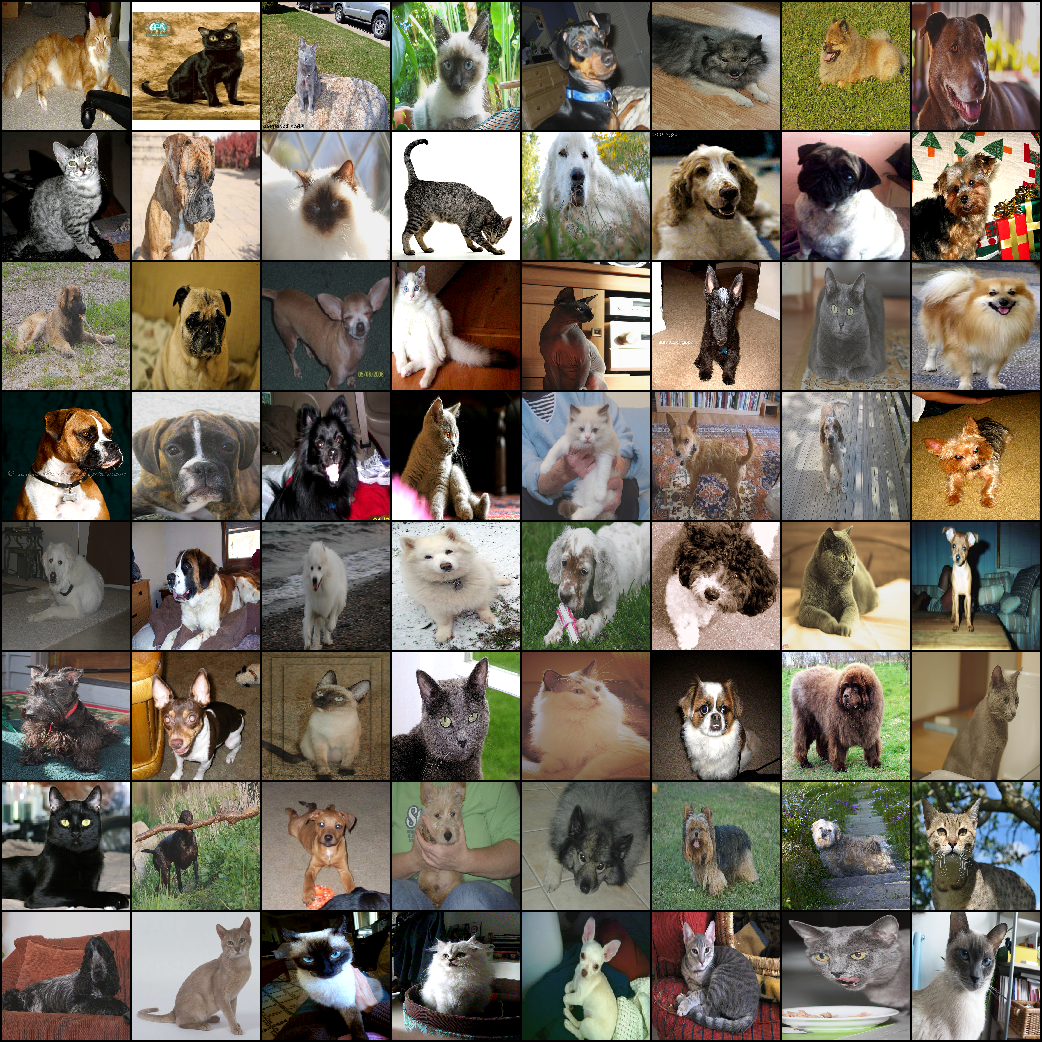

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

ToPILImage()(make_grid(pet_trainval_inputs, nrow=8))

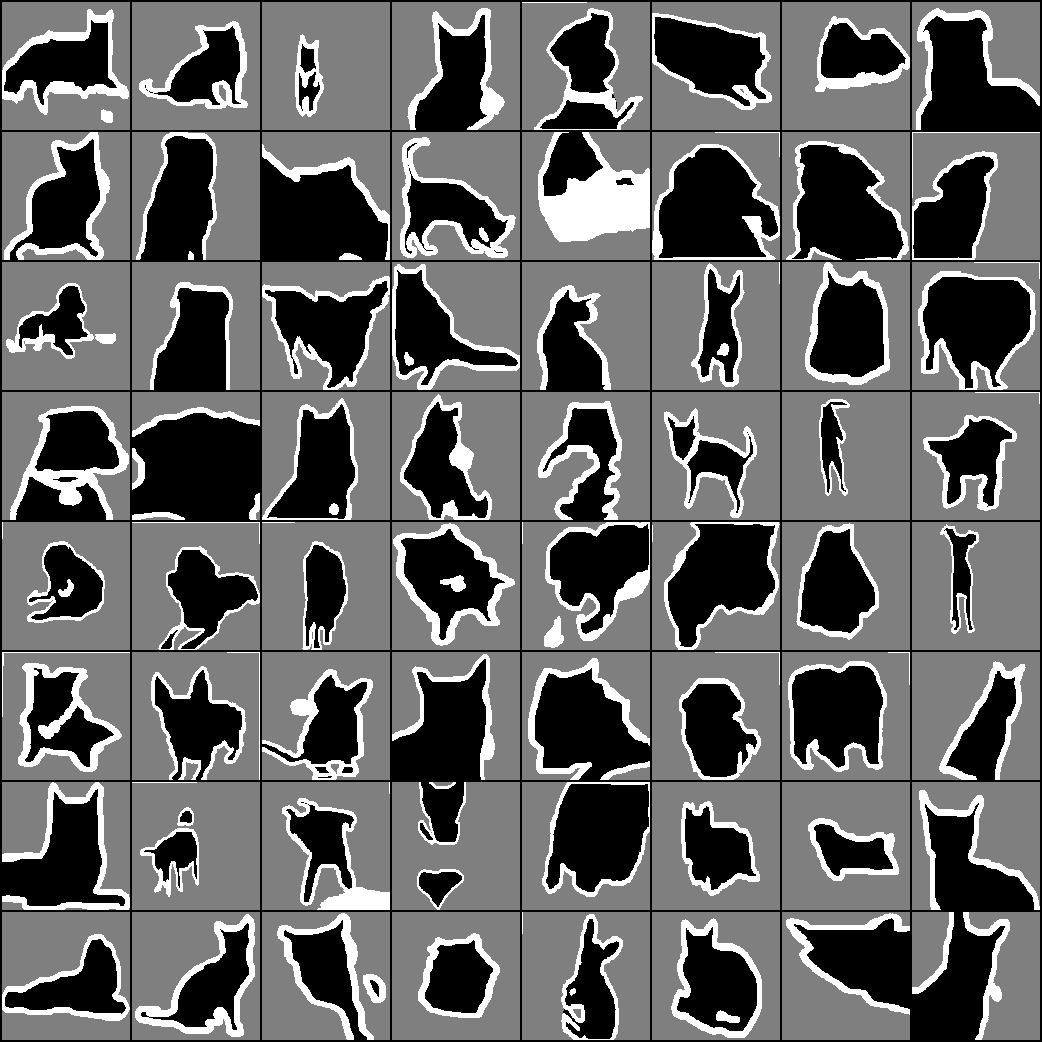

In [ ]:
# input \in {0, 1, 2} -> divide by 2.0 to normalize to [0, 1]
ToPILImage()(make_grid(pet_trainval_masks / 2.0, nrow=8))

In [8]:
# Make sure the model is working
from src import seg_net, to_device
reload(seg_net)
reload(to_device)
ImageSegmentation = seg_net.ImageSegmentation
get_device = to_device.get_device

model = ImageSegmentation(kernel_size=3)
model.eval()
device = get_device()
model.to(device)
model(pet_trainval_inputs.to(device)).shape

torch.Size([64, 3, 128, 128])

In [31]:
from src import iou_metric
reload(iou_metric)
IoULoss = iou_metric.IoULoss
from torch import rand, randint, long

def test_custom_iou_loss():
  #         N, C, H, W
  x = rand((2, 3, 2, 2), requires_grad=True)
  y = randint(0, 3, (2, 1, 2, 2), dtype=long)
  z = IoULoss(softmax=True)(x, y)
  return z

test_custom_iou_loss()

tensor(1.7093, grad_fn=<NegBackward0>)

# Model Training